In [36]:
#Se importan las bibliotecas a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
#Se importan las bases de datos
df_train = pd.read_parquet("./Datasets/train.parquet")
df_test = pd.read_parquet("./Datasets/test.parquet")

In [38]:
#Se da una primera mirada a los tipo de datos y los valores nulos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346479 entries, 0 to 346478
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       346479 non-null  int64  
 1   url                      346479 non-null  object 
 2   region                   346479 non-null  object 
 3   region_url               346479 non-null  object 
 4   price                    346479 non-null  int64  
 5   type                     346479 non-null  object 
 6   sqfeet                   346479 non-null  int64  
 7   beds                     346479 non-null  int64  
 8   baths                    346479 non-null  float64
 9   cats_allowed             346479 non-null  int64  
 10  dogs_allowed             346479 non-null  int64  
 11  smoking_allowed          346479 non-null  int64  
 12  wheelchair_access        346479 non-null  int64  
 13  electric_vehicle_charge  346479 non-null  int64  
 14  come

Text(0.5, 1.0, 'Porcentaje de nulos por columna')

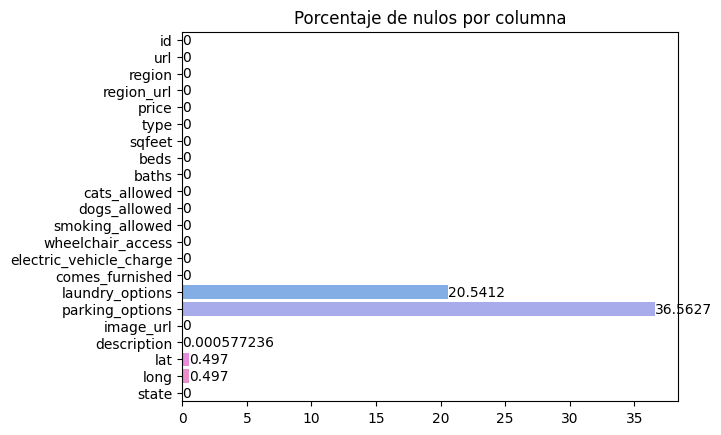

In [39]:
#Se hace una gráfica para visualizar los valores nulos
ax = sns.barplot(x = ((df_train.isnull().sum()*100/df_train.shape[0])).values, y = df_train.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de nulos por columna')

In [40]:
#Como el id y la url no tienen una relación directa con el precio se borran
df_train.drop('id', axis=1, inplace=True)
df_train.drop('url', axis=1, inplace=True)

In [41]:
#MANIPULACION DE DUPLICADOS --> se encuentra que hay 40111 duplicados que deben ser eliminados y así reducir sesgo
df_train.duplicated().sum()
#Se eliminan los duplicados
df_train.drop_duplicates(inplace=True)
#Considerando que las propiedades se pueden republicar y que la columna [image_url] está pensada para que seá exclusiva para un registro se borraran los duplicados de esta columna
df_train.drop((df_train[df_train.duplicated(subset=['image_url'])].index),inplace=True)

In [42]:
#Se redujo el tamaño de la muestra casí a la mitad
print(df_train.shape)

(168246, 20)


In [43]:
# Se hace limpieza de datos por longitud 
# Se establecieron los limites de longitud y latitud de acuerdo con información oficial encontrada para los diferentes estados en estados unidos
# Se usaron valores encontrados en la literatura y se definieron los siguientes intervalos latitud=[19°,66°] longitud= [-155°,-68°]

df_train[(df_train.long >= -60)]
indexlong = df_train[(df_train.long >= -60)].index
df_train.drop(indexlong,inplace=True)

#Limpiar datos por latitude
indexlat= (df_train[(df_train.lat < 19) | (df_train.lat > 68)]).index
df_train.drop(indexlat,inplace=True)

In [44]:
#VALORES NULOS COLUMNAS LONGITUD Y LATITUD
print(df_train["lat"].isnull().sum())
print(df_train["long"].isnull().sum())

918
918


In [45]:
#IMPUTACION DE NULOS PARA LONGITUD Y LATITUD SE HARÁN CON BASE A LOS VALORES PROMEDIOS DE ESOS VALORES DE ACUERDO AL ESTADO
# Creando nuevas variables 
df_mean_lat = pd.DataFrame()
df_mean_long= pd.DataFrame()

# Calcular por promedio agrupando 
df_mean_lat = df_train.groupby('state')['lat'].mean()
df_mean_lat=df_mean_lat.T
def_mean_lat_dict = df_mean_lat.to_dict()

df_mean_long = df_train.groupby('state')['long'].mean()
df_mean_long=df_mean_long.T
def_mean_long_dict = df_mean_long.to_dict()

#Ahora se puede hacer el mapeo para imputar nulos
filterlat= df_train.loc[:,'lat'].isna()
filterlong = df_train.loc[:,'long'].isna()
df_train.loc[filterlat, 'lat'] = df_train.loc[filterlat,"state"].map(def_mean_lat_dict)
df_train.loc[filterlong, 'long'] = df_train.loc[filterlong,"state"].map(def_mean_long_dict)

<AxesSubplot:xlabel='long', ylabel='lat'>

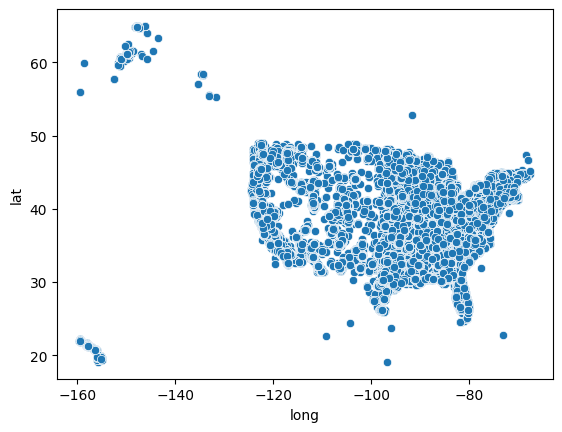

In [46]:
#Se realiza gráfico que relaciona latitud y longitud y se ve que los datos se relacionan mejor
sns.scatterplot(x= df_train.long, y= df_train.lat)

In [47]:
#COLUMNS sqfeet borrar valores de cero
#Eliminar valores de 0 para el sqfeet que representan el 0.017% de los datos
print(df_train[df_train.sqfeet==0].shape)
print(df_train[df_train.sqfeet==0].shape[0]*100/df_train.shape[0])
print(df_train[df_train.sqfeet==0].index)
df_train.drop(df_train[df_train.sqfeet==0].index,inplace=True)
print(df_train[df_train.sqfeet==0].shape)
print(df_train.shape)

(31, 20)
0.01843054952764285
Int64Index([  4391,   5191,  17054,  45445,  46723,  48157,  49827,  56777,
             82353,  84304,  92489,  96855,  99563, 108209, 122857, 124652,
            126427, 142634, 154782, 181344, 187054, 188902, 195096, 197290,
            218523, 251945, 263670, 283134, 285026, 296637, 337829],
           dtype='int64')
(0, 20)
(168168, 20)


In [48]:
# COLUMNA SQFEET HAY OUTLIERS --> REMOVER OUTLIERS REGLA 3 sigma
df_train.drop(df_train[df_train.sqfeet>6000000].index,inplace=True)

# calcular desviacion estandar y promedio
std = df_train['sqfeet'].std()
mean = df_train['sqfeet'].mean()

# Calcular los límites superior e inferior
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Eliminar Outliers
df_train[(df_train['sqfeet'] > upper) | (df_train['sqfeet'] < lower)].shape
df_train.drop(df_train[(df_train['sqfeet'] > upper) | (df_train['sqfeet'] < lower)].index,inplace=True)

In [49]:
#Se van a elimira los valores de precio= 0 ya que representan el 0.3% de los datos
print(df_train[df_train.price==0].shape[0]*100/df_train.shape[0])
print(df_train.shape)
print(df_train[df_train.price==0].shape[0])
df_train.drop(df_train[df_train.price==0].index,inplace=True)

0.36634393510478863
(168148, 20)
616


In [50]:
# COLUMNA PRECIO HAY OUTLIERS --> REMOVER OUTLIERS REGLA 3 sigma
# calcular desviacion estandar y promedio
std = df_train['price'].std()
mean = df_train['price'].mean()

# Calcular los límites superior e inferior
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Eliminar Outliers
df_train[(df_train['price'] > upper) | (df_train['price'] < lower)].shape
df_train.drop(df_train[(df_train['price'] > upper) | (df_train['price'] < lower)].index,inplace=True)

count    167531.000000
mean          1.984343
std           4.469185
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1100.000000
Name: beds, dtype: float64
count    167528.000000
mean          1.965874
std           0.941228
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           8.000000
Name: beds, dtype: float64


<AxesSubplot:>

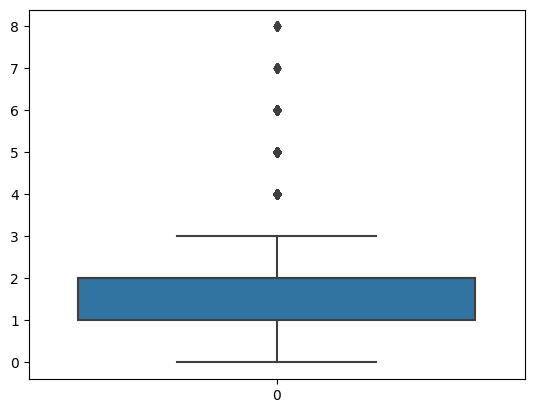

In [51]:
#COLUMAN BEDS --> SE ELIMINA EL VALOR MÁXIMO QUE APARECE EN LA COLUMNA CONSIDERANDOLO COMO OUTLIER
#Column beds - Se borra el outlier > 1000
print(df_train["beds"].describe())
df_train.drop(df_train[df_train.beds>999].index,inplace=True)
print(df_train["beds"].describe())
sns.boxplot(df_train["beds"])

In [52]:
# COLUMN BEDS HAY OUTLIERS --> REMOVER OUTLIERS REGLA 3 sigma
# calcular desviacion estandar y promedio
std = df_train['beds'].std()
mean = df_train['beds'].mean()

# Calcular los límites superior e inferior
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Eliminar Outliers
df_train[(df_train['beds'] > upper) | (df_train['beds'] < lower)].shape
df_train.drop(df_train[(df_train['beds'] > upper) | (df_train['beds'] < lower)].index,inplace=True)

count    165580.000000
mean          1.479659
std           0.595512
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: baths, dtype: float64


(1195, 20)

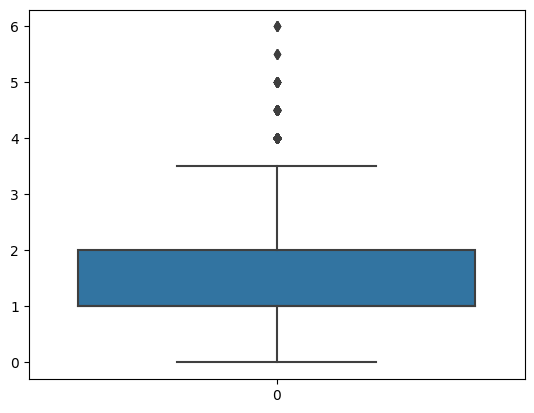

In [53]:
#COLUMNA BATHS - CUENTA CON OUTLIERS LOS CUALES SE PUEDEN ELIMINAR
print(df_train["baths"].describe())
sns.boxplot(df_train["baths"])
df_train[(df_train.baths>3)&(df_train.beds<=8)].shape

In [54]:
# COLUMN BATHS --> REMOVER OUTLIERS REGLA DE 3 SIGMA
# calcular desviacion estandar y promedio
std = df_train['baths'].std()
mean = df_train['baths'].mean()

# Calcular los límites superior e inferior
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Eliminar Outliers
df_train[(df_train['baths'] > upper) | (df_train['baths'] < lower)].shape
df_train.drop(df_train[(df_train['baths'] > upper) | (df_train['baths'] < lower)].index,inplace=True)

Text(0.5, 1.0, 'Porcentaje de nulos por columna')

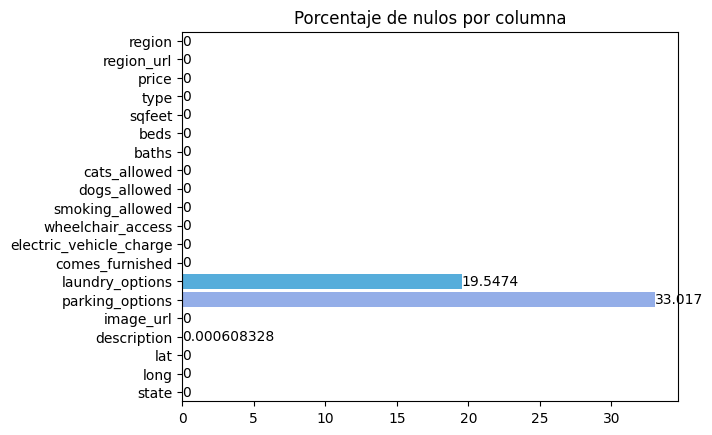

In [55]:
ax = sns.barplot(x = ((df_train.isnull().sum()*100/df_train.shape[0])).values, y = df_train.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de nulos por columna')

In [56]:
#SE HACE LA BINARIZACIÓN DE LA COLUMNA PRECIO GENERANDO LOS VALORES CATEGORICOS QUE SERAN EL TARGET DE LA PREDICCION
df_train['category_price'] = 0
df_train.loc[df_train['price'] < 999, 'category_price'] = 1
df_train[['price','category_price']]

,price,category_price
0,1350,0
1,1115,0
2,1129,0
3,1580,0
4,995,1
...,...,...
346460,1565,0
346462,479,1
346466,3155,0
346475,2122,0


In [57]:
#MANIPULACION COLUMNA LOUNDRY EN LA COLUMNA LOUNDRY HAY 32133
print("El número de nulos para loundry es : ", df_train["laundry_options"].isnull().sum())

El número de nulos para loundry es :  32133


In [58]:
#IMPUTACION DE NULOS PARA LAUNDRY CON FILTRADO POR TIPO DE PROPIEDAD SELECCIONANDO LOS VALORES QUE SE REPITEN CON MAYOR FRECUENCIA
df_typeLaundry=df_train.groupby('type')['laundry_options'].value_counts()

dic_type_laundry = {'apartment':'laundry on site',
                    'assisted living':'laundry on site',
                    'condo':'w/d in unit',
                    'cottage/cabin':'no laundry on site',
                    'duplex':'w/d hookups',
                    'flat':'w/d in unit',
                    'townhouse':'w/d in unit',
                    'manufactured':'w/d hookups',
                    'loft':'w/d in unit',
                    'land':'w/d in unit',
                    'in-law':'w/d in unit',
                    'house':'w/d hookups'}

#Ahora se puede Hacer el mapeo para eliminar los valores nulos 
filter_laundry = df_train.loc[:,'laundry_options'].isna()
df_train.loc[filter_laundry, 'laundry_options'] = df_train.loc[filter_laundry,"type"].map(dic_type_laundry)

In [59]:
#MANIPULACION COLUMNA LOUNDRY
print("El número de nulos para loundry es : ", df_train["laundry_options"].isnull().sum())

El número de nulos para loundry es :  0


In [60]:
#CODIFICAR COLUMNA LOUNDRY
laundry_dict = {"w/d in unit":1,
                "w/d hookups":2,
                "laundry on site":3,
                "laundry in bldg":4,
                "no laundry on site":5}

df_train.replace({'laundry_options':laundry_dict},inplace=True)

In [61]:
#IMPUTACION DE NULOS PARA PARKING OPTIONS CON FILTRADO POR TIPO DE PROPIEDAD
df_typeParking=df_train.groupby('type')['parking_options'].value_counts()

dict_type_parking = {'apartment':"off-street parking",
                    'assisted living':'off-street parking',
                    'condo':'attached garage',
                    'cottage/cabin':'off-street parking',
                    'duplex':'off-street parking',
                    'flat':'off-street parking',
                    'townhouse':'carport',
                    'loft':'off-street parking',
                    'land':'off-street parking',
                    'in-law':'off-street parking',
                    'house':'attached garage',
                    'manufactured':'off-street parking'}

#Ahora se puede Hacer el mapeo
filter_parking = df_train.loc[:,'parking_options'].isna()
df_train.loc[filter_parking , 'parking_options'] = df_train.loc[filter_parking ,'type'].map(dict_type_parking)

In [62]:
#CODIFICAR COLUMNA parking options SEGÚN LOS VALORES ÚNICOS
parking_dict = {"off-street parking":1,
                "attached garage":2,
                "carport":3,
                "detached garage":4,
                "street parking":5,
                "no parking":6,
                "valet parking":7}

df_train.replace({'parking_options':parking_dict},inplace=True)
print(df_train["parking_options"].value_counts())

1    99524
2    29350
3    18165
4     8452
5     7730
6     1054
7      110
Name: parking_options, dtype: int64


Text(0.5, 1.0, 'Porcentaje de nulos por columna')

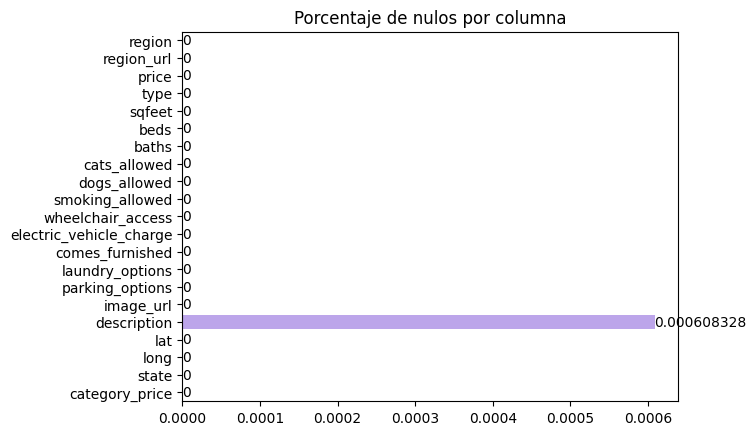

In [63]:
ax = sns.barplot(x = ((df_train.isnull().sum()*100/df_train.shape[0])).values, y = df_train.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de nulos por columna')

C:\Users\julia\AppData\Local\Temp\ipykernel_29856\1366125141.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train[['type','sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','category_price']].corr(),annot=True, cmap="coolwarm")


Text(0.5, 1.0, 'Mapa de correlaciones')

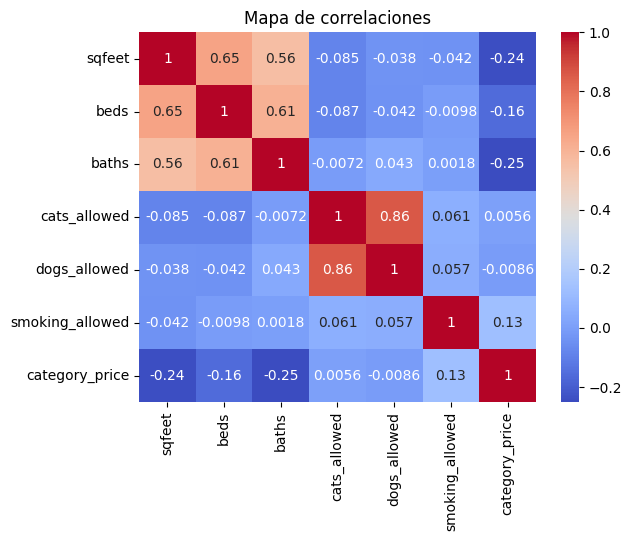

In [64]:
import numpy as np
df_train.select_dtypes(include = ['int64','int','float']).columns
numerical_columns =  ['price','type','sqfeet','beds',
        'baths','cats_allowed','dogs_allowed',
        'smoking_allowed','wheelchair_access','electric_vehicle_charge',
        'comes_furnished','laundry_options','parking_options','lat',
        'long','category_price']

#Mapa de correlaciones lineales (acá se puede ver que tparametros tienen la mejor correlación)
sns.heatmap(df_train[['type','sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','category_price']].corr(),annot=True, cmap="coolwarm")
plt.title('Mapa de correlaciones')

Text(0.5, 1.0, 'Mapa de correlaciones')

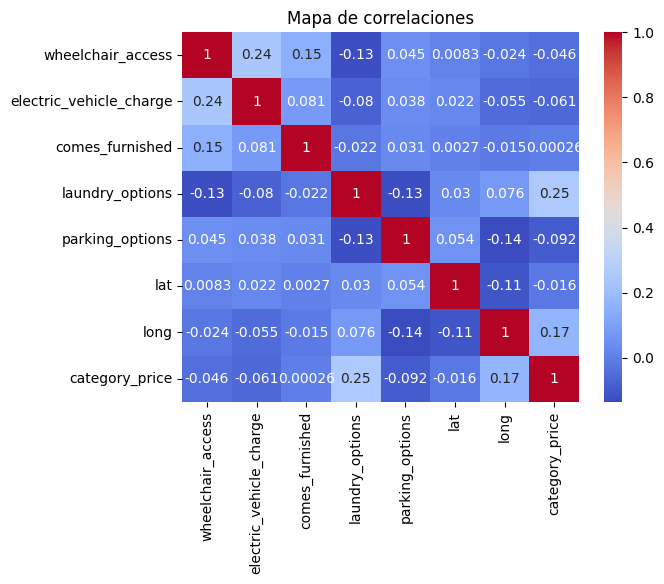

In [65]:
sns.heatmap(df_train[['wheelchair_access','electric_vehicle_charge','comes_furnished','laundry_options','parking_options','lat','long','category_price']].corr(),annot=True, cmap="coolwarm")
plt.title('Mapa de correlaciones')

In [66]:
#Se exporta el archivo de entrenamiento a un csv que sera luego usado para la aplicación del módelo de predicción
df_train.to_csv('train_modelo.csv',index=False)

In [67]:
#MANIPULACIONES EN EL TEST SET

df_test = pd.read_parquet("./Datasets/test.parquet")
# -------------------------------------------------------------------------------------------
#COLUMNA LAUNDRY OPTIONS - MANIPULACION NULOS Y CODIFICACION
#IMPUTACION DE NULOS PARA LAUNDRY CON FILTRADO POR TIPO DE PROPIEDAD
df_typeLaundry=df_test.groupby('type')['laundry_options'].value_counts()

dic_type_laundry = {'apartment':'laundry on site',
                    'assisted living':'laundry on site',
                    'condo':'w/d in unit',
                    'cottage/cabin':'no laundry on site',
                    'duplex':'w/d hookups',
                    'flat':'w/d in unit',
                    'townhouse':'w/d in unit',
                    'manufactured':'w/d hookups',
                    'loft':'w/d in unit',
                    'land':'w/d in unit',
                    'in-law':'w/d in unit',
                    'house':'w/d hookups'}

#Ahora se puede Hacer el mapeo para eliminar los valores nulos 
filter_laundry = df_test.loc[:,'laundry_options'].isna()
df_test.loc[filter_laundry, 'laundry_options'] = df_test.loc[filter_laundry,"type"].map(dic_type_laundry)

laundry_dict = {"w/d in unit":1,
                "w/d hookups":2,
                "laundry on site":3,
                "laundry in bldg":4,
                "no laundry on site":5}

df_test.replace({'laundry_options':laundry_dict},inplace=True)
#----------------------------------------------------------------------------------------
#COLUMN PARKING
#IMPUTACION DE NULOS PARA PARKING OPTIONS CON FILTRADO POR TIPO DE PROPIEDAD
df_typeParking=df_test.groupby('type')['parking_options'].value_counts()

dict_type_parking = {'apartment':"off-street parking",
                    'assisted living':'off-street parking',
                    'condo':'attached garage',
                    'cottage/cabin':'off-street parking',
                    'duplex':'off-street parking',
                    'flat':'off-street parking',
                    'townhouse':'carport',
                    'loft':'off-street parking',
                    'land':'off-street parking',
                    'in-law':'off-street parking',
                    'house':'attached garage',
                    'manufactured':'off-street parking'}

#Ahora se puede hacer el mapeo
filter_parking = df_test.loc[:,'parking_options'].isna()
df_test.loc[filter_parking , 'parking_options'] = df_test.loc[filter_parking ,'type'].map(dict_type_parking)

#COLUMNA parking_ptions - - CODIFICACION
parking_dict = {"off-street parking":1,
                "attached garage":2,
                "carport":3,
                "detached garage":4,
                "street parking":5,
                "no parking":6,
                "valet parking":7}

df_test.replace({'parking_options':parking_dict},inplace=True)
# ---------------------------------------------------------------
#COLUMNA type - - CODIFICACION
type_dict= {'house':1, 
            'apartment':2, 
           'duplex':3, 
            'loft':4, 
           'condo':5, 
            'manufactured':6,
            'townhouse':7, 
            'in-law':8,
            'cottage/cabin':9,
            'flat':10,
           'assisted living':11,
            'land':12}

df_test.replace({'type':type_dict},inplace=True)

#------------------------------------
#COMPLETAR NULOS LONGITUD Y LATITUD 
#Ahora se puede acer el mapeo-para ello se usan los valores promedio cálculados en el set de entrenamiento
filterlat= df_test.loc[:,'lat'].isna()
filterlong = df_test.loc[:,'long'].isna()
df_test.loc[filterlat, 'lat'] = df_test.loc[filterlat,"state"].map(def_mean_lat_dict)
df_test.loc[filterlong, 'long'] = df_test.loc[filterlong,"state"].map(def_mean_long_dict)


Text(0.5, 1.0, 'Porcentaje de nulos por columna')

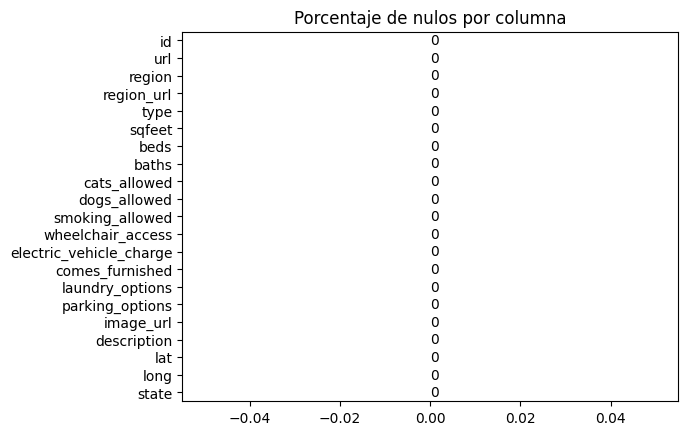

In [68]:
# Se verificcan que en el test set no hayan valores nulos
ax = sns.barplot(x = ((df_test.isnull().sum()*100/df_test.shape[0])).values, y = df_test.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de nulos por columna')

In [69]:
#Importar el archivo de test que luego sera usado en el modelo predictivo
df_test.to_csv('test_modelo.csv',index=False)